In [1]:
import base64
import datetime
import json
import os
import random
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image

np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

pd.options.display.max_colwidth = 1000

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Load the Data

In [3]:
raw_data = pd.read_json('tmp/raw_data.json')
d = pd.read_json('tmp/raw_data.json')
raw_data.index.name = 'id'
d = raw_data[['street_address']]
dd  = raw_data[['street_address', 'display_address']]
print len(d)

124011


In [4]:
d.dtypes

street_address    object
dtype: object

In [5]:
dd.head()

,street_address,display_address
id,,
0,99 Suffolk Street,Suffolk Street
1,176 Thompson Street,Thompson Street
10,792 Metropolitan Avenue,Metropolitan Avenue
100,101 East 10th Street,101 East 10th Street
1000,251 South Third Street\r,South Third Street\r


In [6]:
#dd[dd.street_address == dd.display_address].value_counts()
(dd.street_address == dd.display_address).value_counts()

False    112897
True      11114
dtype: int64

## Number of words

Here I count numbers of abbreviations as words, so it's rather the number of tokens.

/Library/Python/2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Python/2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


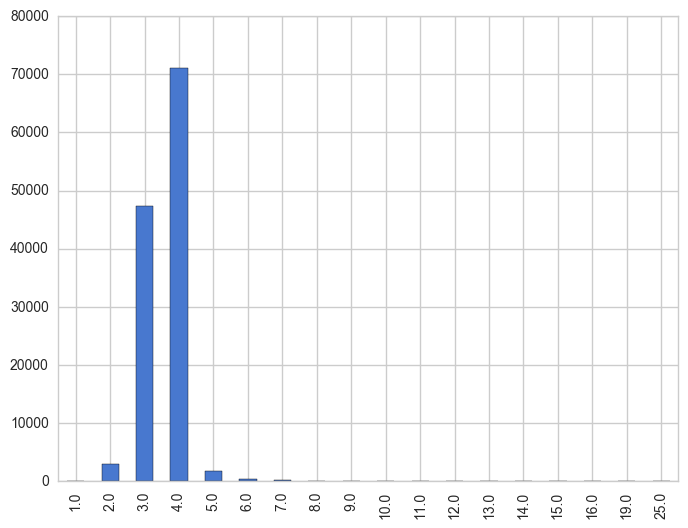

In [7]:
# number of words
# daddr_num_words
def tokens(x):
    return len(x.split(' '))
d.loc[:, 'saddr_num_words'] = d.street_address.map(lambda x: tokens(x)).astype(float64)
d.saddr_num_words.value_counts().sort_index().plot(kind='bar')

## Does the address contain any numbers?

If the address contains number, then we can assume it's the exact address, not only the street or neighborhood name.

In [8]:
def represents_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def has_number(x):
    return int(any([represents_int(w.strip()) for w in x.split(' ')]))
    
d.loc[:, 'saddr_has_number'] = d.street_address.map(lambda x: has_number(x))
d.head()

,street_address,saddr_num_words,saddr_has_number
id,,,
0,99 Suffolk Street,3.0,1
1,176 Thompson Street,3.0,1
10,792 Metropolitan Avenue,3.0,1
100,101 East 10th Street,4.0,1
1000,251 South Third Street\r,5.0,1


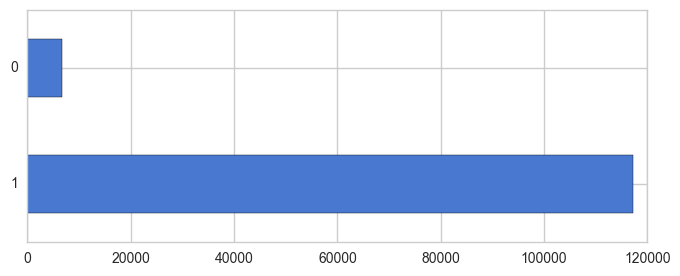

In [9]:
d.saddr_has_number.value_counts().plot(kind='barh', figsize=(8,3))

## Does the address contain any ordinal numbers?


In [10]:
import re
p = re.compile('[0-9]+[a-z]+')

def is_ordinal(w):    
    return p.match(w) != None

def has_ordinal_number(x):
    return int(any([is_ordinal(w.strip().lower()) for w in x.split(' ')]))
    
d.loc[:, 'saddr_has_ordinal'] = d.street_address.map(lambda x: has_ordinal_number(x))
d.head()

,street_address,saddr_num_words,saddr_has_number,saddr_has_ordinal
id,,,,
0,99 Suffolk Street,3.0,1,0
1,176 Thompson Street,3.0,1,0
10,792 Metropolitan Avenue,3.0,1,0
100,101 East 10th Street,4.0,1,1
1000,251 South Third Street\r,5.0,1,0


## Number of uppercase words

Note that there are a lot of addresses that contain a single-letter "word" which is uppercase, usually referring to East, West, etc
For example: E 78th St., W 68 Street.
I've excluded these single letter words because I think it's ok to treat them as normal.

In [11]:
import re
uppercase_pattern = re.compile('^[A-Z]+$')


def is_uppercase(w):    
    return uppercase_pattern.match(w) != None

def uppercase_word_count(x):
    return len([w for w in x.split(' ') if is_uppercase(w.strip()) and len(w) > 1])
    
d.loc[:, 'saddr_num_upper_words'] = d.street_address.map(lambda x: uppercase_word_count(x)).astype(float64)
d.head()

,street_address,saddr_num_words,saddr_has_number,saddr_has_ordinal,saddr_num_upper_words
id,,,,,
0,99 Suffolk Street,3.0,1,0,0.0
1,176 Thompson Street,3.0,1,0,0.0
10,792 Metropolitan Avenue,3.0,1,0,0.0
100,101 East 10th Street,4.0,1,1,0.0
1000,251 South Third Street\r,5.0,1,0,0.0


In [12]:
d[d.saddr_num_upper_words >2].head()

,street_address,saddr_num_words,saddr_has_number,saddr_has_ordinal,saddr_num_upper_words
id,,,,,
100600,UWS! NO FEE NO FEE****as,6.0,0,0,3.0
105725,MURRAY HILL NO FEES SPECTACULAR,5.0,0,0,5.0
10720,930 ST NICHOLAS AVE,4.0,1,0,3.0
107529,128 ST MARKS PL,4.0,1,0,3.0
109702,Hamilton Heights NO BROKER'S FEES SPECTACULAR,6.0,0,0,3.0


In [13]:
d.saddr_num_upper_words.value_counts()

0.0    122583
1.0       835
2.0       530
3.0        42
4.0        18
5.0         3
Name: saddr_num_upper_words, dtype: int64

### Is street address the same as display address?

In [14]:
d.loc[:, 'daddr_saddr_same'] = (dd.street_address == dd.display_address).map(int)
d.head()

,street_address,saddr_num_words,saddr_has_number,saddr_has_ordinal,saddr_num_upper_words,daddr_saddr_same
id,,,,,,
0,99 Suffolk Street,3.0,1,0,0.0,0
1,176 Thompson Street,3.0,1,0,0.0,0
10,792 Metropolitan Avenue,3.0,1,0,0.0,0
100,101 East 10th Street,4.0,1,1,0.0,1
1000,251 South Third Street\r,5.0,1,0,0.0,0


# Num Apts with the Same Street Address

In [15]:
def clean_sa_str(s):
    s = re.sub('\W', ' ', s)
    s = re.sub('\s+', ' ', s)
    s = s.strip()
    return s.lower()
d['clean_sa'] = d.street_address.apply(clean_sa_str)
d.clean_sa.head()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


id
0             99 suffolk street
1           176 thompson street
10      792 metropolitan avenue
100        101 east 10th street
1000     251 south third street
Name: clean_sa, dtype: object

In [16]:
cnt = Counter(d.clean_sa.tolist())
d['num_apts_with_same_saddr'] = d.clean_sa.map(cnt).astype(float64)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Word Counts

In [17]:
NUM_COUNT_FEATURES = 20
cv = CountVectorizer(stop_words=None, max_features=NUM_COUNT_FEATURES)
cv.fit(d.clean_sa)
voc = {v: k for k, v in cv.vocabulary_.iteritems()}
dc = pd.DataFrame(cv.transform(d.clean_sa).todense())
dc.columns = [('saddr_count_' + voc[i]) for i in range(NUM_COUNT_FEATURES)]
for c in dc.columns:
    d[c] = dc[c]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Save the Data

In [18]:
del d['street_address']
del d['clean_sa']

In [19]:
d.to_csv('tmp/features_street_address.csv', encoding='utf-8’')